In [1]:
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
import os 
import fnmatch
sys.path.insert(1, r"C:\Users\nelg\Desktop\Cours\Labo\TP4\Git\utils")
sys.path.insert(1, r"C:\Users\nelg\Desktop\Cours\Labo\TP4\Git\tracking")
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display


In [2]:
# Define the paths needed
raw_data_directory = r"C:\Users\nelg\Desktop\Cours\Labo\TP4\run_000400\\" #path to the ecal data
current_directory = os.getcwd()
data_storage = current_directory+r"\extracted_data\\"
suffix = "_5h_1Hz"

In [3]:
# Load the data
files = fnmatch.filter(os.listdir(raw_data_directory), '*.root')

for i,file in enumerate(files):
    if i == 0:
        df = [load_dataset(raw_data_directory+file)]
    else:
        df_i = load_dataset(raw_data_directory+file)
        df_i.index += df[-1].index[-1]+1
        df.append(df_i)

df_hits_total = pd.concat(df)
df_hits = pd.DataFrame.copy(df_hits_total, deep=True)

og_len = len(df_hits_total)

df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)

new_len = len(df_hits)

print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 16.55% of all events


In [17]:
## This function finds the indices of event which are good candidate for muon decay : good tracks that don't end on a side of the detector
## and that have enough hits on both planes
def create_candidate_tracks(df, plot = False):
    candidate_index = []
    low_number = 0
    bottom_touch = 0
    side_touch = 0
    bad_fit = 0
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            #One only considers the events for which the potential track ended inside the detector
            hitsX.sort(key = lambda hit: -hit.coord[1])
            hitsY.sort(key = lambda hit: -hit.coord[1])
            if hitsX[-1].coord[1] > 1 and hitsY[-1].coord[1] > 1:
                hitsX_last = [hit for hit in hitsX if hit.coord[1]==hitsX[-1].coord[1]]
                hitsY_last = [hit for hit in hitsY if hit.coord[1]==hitsY[-1].coord[1]]
                X_ok = True
                Y_ok = True
                for hit in hitsX_last:
                    if hit.coord[0] == 1 or hit.coord[0] == 24:
                        X_ok = False
                        side_touch += 1
                for hit in hitsY_last:
                    if hit.coord[0] == 1 or hit.coord[0] == 24:
                        Y_ok = False
                        if X_ok:
                            side_touch += 1
                if X_ok and Y_ok:
                    # get track parameters
                    track = Track3D(hits)

                    ## check if track has a "good" chi2 value
                    if track.is_good_2D_fit():
                        candidate_index.append(index)
                    else:
                        bad_fit += 1
            else:
                bottom_touch += 1
        else:
            low_number += 1
    
    return candidate_index, low_number, bottom_touch, side_touch, bad_fit

In [4]:
candidate_index, low_number, bottom_touch, side_touch, bad_fit = create_candidate_tracks(df_hits)

100%|██████████| 287754/287754 [10:47<00:00, 444.39it/s]


In [8]:
np.savetxt(data_storage+"candidate_muon_stopping"+suffix+".txt",candidate_index)

In [5]:
candidate_index = np.loadtxt(data_storage+"candidate_muon_stopping"+suffix+".txt")

In [ ]:
# This cell allows to check the selected events, as well as the next recorded event (where the muon decay should be observed)
%matplotlib inline
i = 0
kb = ""
while kb == "":
    event = df_hits.loc[candidate_index[i]]
    next_event = df_hits_total.loc[candidate_index[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits'])]
    hitsX = [h for h in hits if h.is_sidex]
    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    hitsX_next_event = [h for h in hits_next_event if h.is_sidex]

    track = Track(hitsX)
    fig,ax = plot_hits(hits,True,True,scaling=0.5)
    fig_next_event,ax_next_event = plot_hits(hits_next_event,True,True,scaling=0.5)
    z = np.linspace(0,16)
    x = track.t*z+track.x0
    ax.plot(x,z,'r-')
    display.clear_output(wait=False)
    print(hits_next_event[0].timestamp_event-hits_next_event[0].timestamp-hits[-1].timestamp_event+hits[-1].timestamp)
    display.display(fig)
    display.display(fig_next_event)
    kb = input()
    i = i+1

display.clear_output(wait=False)

In [7]:
# This cell filters out the candidates for which the next event happens too long after for it to be the result of a muon decay,
# and the one for which the hits in the next event are too far from the end of the original track
good_candidates = []
too_large_time_interval = 0
no_spacial_correlation = 0
hits_far_from_track = 0

for j in candidate_index:
    event = df_hits.loc[j]
    next_event = df_hits_total.loc[j+1]
    hits = [Hit(event,i) for i in range(event['n_hits'])]
    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    hitsX = [hit for hit in hits if hit.is_sidex]
    hitsY = [hit for hit in hits if not hit.is_sidex]
    hitsX_next_event = [hit for hit in hits_next_event if hit.is_sidex]
    hitsY_next_event = [hit for hit in hits_next_event if not hit.is_sidex]

    track = Track3D(hits)

    hitsX = [hit for hit in hitsX if dist_line_rect(track.x.t, track.x.x0, hit.get_pos(), thickness, width) < Delta_z] #Keep only the hits close to the track
    hitsY = [hit for hit in hitsY if dist_line_rect(track.y.t, track.y.x0, hit.get_pos(), thickness, width) < Delta_z]


    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    if hits_next_event[0].timestamp_event-hits[0].timestamp_event < 1500: #muon lifetime in clock cycles = 351 -> keeps only events correlated in time with the next measured event
        hitsX.sort(key = lambda hit: -hit.get_pos()[1])
        hitsY.sort(key = lambda hit: -hit.get_pos()[1])
        
        X_near = False
        Y_near = False
        if len(hitsX) == 0 and len(hitsY) == 0:
            hits_far_from_track += 1
        else:
            if len(hitsX) != 0:
                for h in hitsX_next_event:
                    if np.linalg.norm(h.get_pos()-hitsX[-1].get_pos()) < 4:
                        X_near = True
            if len(hitsY) != 0:
                for h in hitsY_next_event:
                    if np.linalg.norm(h.get_pos()-hitsY[-1].get_pos()) < 4:
                        Y_near = True
            if X_near and Y_near:
                good_candidates.append(j)
            else:
                no_spacial_correlation += 1
    else:
        too_large_time_interval += 1

good_candidates = np.array(good_candidates)
np.savetxt(data_storage+"final_muon_decay_candidates"+suffix+".txt",good_candidates)
    


In [8]:
filtering = pd.DataFrame({'og_len' : [og_len],
                        'new_len' : [new_len],
                        'low_number' : [low_number],
                        'bottom_touch' : [bottom_touch],
                        'side_touch' : [side_touch],
                        'bad_fit': [bad_fit],
                        'too_large_time_interval' : [too_large_time_interval],
                        'hits_far_from_track' : [hits_far_from_track],
                        'no_spacial_correlation' : [no_spacial_correlation]})
filtering.to_pickle(data_storage+"filtering_data"+suffix)

In [5]:
filtering = pd.read_pickle(data_storage+"filtering_data"+suffix)
# og_len = filtering['og_len'][0]
# new_len = filtering['new_len'][0]
low_number = filtering['low_number'][0]
bottom_touch = filtering['bottom_touch'][0]
side_touch = filtering['side_touch'][0]
bad_fit = filtering['bad_fit'][0]
too_large_time_interval = filtering['too_large_time_interval'][0]
hits_far_from_track = filtering['hits_far_from_track'][0]
no_spacial_correlation = filtering['no_spacial_correlation'][0]

In [8]:
# Showcase of the numbers of rejection at each step of the filtering 
print("original length : ", og_len)
print("n_hits between 6 and 50 : ", new_len)
n = new_len
print("\u2937 Too low number of hits in one plane : ", low_number, " over ", n)
n -= low_number
print(" \u2937 Last layer touched : \t\t", bottom_touch, " over ", n)
n -= bottom_touch
print("  \u2937 Possible side exit : \t\t", side_touch, " over ", n)
n -= side_touch
print("   \u2937 Bad fit : \t\t\t\t", bad_fit, " over ", n)
n -= bad_fit
print("    \u2937 Too large time interval : \t", too_large_time_interval, " over ", n)
n -= too_large_time_interval
print("     \u2937 Hits far from track : \t\t", hits_far_from_track, " over ", n)
n -= hits_far_from_track
print("      \u2937 No spacial correlation : \t", no_spacial_correlation, " over ", n)
print("Final number : ", len(good_candidates))

original length :  1739062
n_hits between 6 and 50 :  287754
⤷ Too low number of hits in one plane :  45062  over  287754
 ⤷ Last layer touched : 		 189126  over  242692
  ⤷ Possible side exit : 		 24082  over  53566
   ⤷ Bad fit : 				 16209  over  29484
    ⤷ Too large time interval : 	 12560  over  13275
     ⤷ Hits far from track : 		 0  over  715
      ⤷ No spacial correlation : 	 590  over  715
Final number :  141


In [7]:
good_candidates = np.loadtxt(data_storage+"final_muon_decay_candidates"+suffix+".txt")

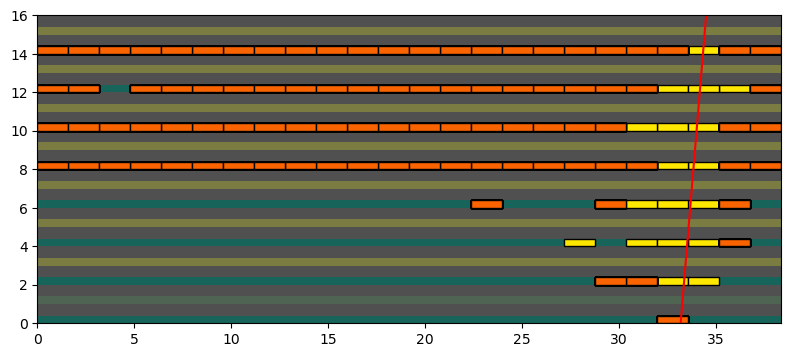

In [12]:
#This cell allows to plot the final candidates for muon decay (original track + next event)
%matplotlib inline
i = 13
kb = ""
while kb == "":
    event = df_hits.loc[good_candidates[i]]
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits'])]
    hitsX = [h for h in hits if h.is_sidex]
    hits_next_event = [Hit(next_event,i) for i in range(next_event['n_hits'])]
    hitsX_next_event = [h for h in hits_next_event if h.is_sidex]

    track = Track(hitsX)
    fig,ax = plot_hits(hits,True,True,scaling = 0.5,hits_next = hits_next_event)
    z = np.linspace(0,16)
    x = track.t*z+track.x0
    ax.plot(x,z,'r-')
    display.clear_output(wait=False)
    print(hits_next_event[0].timestamp_event-hits_next_event[0].timestamp-hits[-1].timestamp_event+hits[-1].timestamp)
    # fig.savefig("fig_muon_decay_{}.jpg".format(i))
    display.display(fig)
    kb = input()
    i = i+1

display.clear_output(wait=False)

In [23]:
# Compute the time intervals between the muon tracks and the muon decays
good_candidates = np.loadtxt(data_storage+"final_muon_decay_candidates"+suffix+".txt").astype(int)
time_intervals = []
t_clock_cycle = 6.25

for i in good_candidates:
    t_muon = df_hits.loc[i]['timestamp_event']
    t_decay = df_hits_total.loc[i+1]['timestamp_event']
    time_intervals.append((t_decay-t_muon)*t_clock_cycle)

time_intervals = np.array(time_intervals)
np.savetxt(data_storage+"time_intervals"+suffix+".txt",time_intervals)
